In [ ]:
import tensorflow as tf
from tensorflow.contrib.framework import arg_scope
from tensorflow.contrib import layers
from tensorflow.contrib.framework import arg_scope



# {{{ AdamaxOptimizer()
# Implementation of Adamax optimizer, taken from : 
# https://github.com/openai/iaf/blob/master/tf_utils/adamax.py
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.framework import ops
from tensorflow.python.training import optimizer

In [ ]:
tf.__version__

In [ ]:
class _Model():

    def __init__(self, is_training=None):

        if tf.test.is_gpu_available():
            data_format='NCHW'
        else:
            data_format='NHWC'

        self.data_format = data_format                                           
        if is_training is None:                                                  
            self.is_training = tf.get_variable('is_training', dtype=tf.bool, 
                                    initializer=tf.constant_initializer(True),
                                    trainable=False) 
        else:                                                                    
            self.is_training = is_training

    def _build_losses(self, labels):
        self.labels = tf.cast(labels, tf.int64)                                  
        with tf.variable_scope('loss'):                                          
            oh = tf.one_hot(self.labels, 2)                                      
            xen_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(  
                                                    labels=oh,logits=self.outputs))
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)   
            self.loss = tf.add_n([xen_loss] + reg_losses)                        
        with tf.variable_scope('accuracy'):                                      
            am = tf.argmax(self.outputs, 1)                                      
            equal = tf.equal(am, self.labels)                                    
            self.accuracy = tf.reduce_mean(tf.cast(equal, tf.float32))           
        return self.loss, self.accuracy

class SRNet(_Model):

    def _build_model(self, inputs):
        self.inputs = inputs
        if self.data_format == 'NCHW':
            reduction_axis = [2,3]
            _inputs = tf.cast(tf.transpose(inputs, [0, 3, 1, 2]), tf.float32)
        else:
            reduction_axis = [1,2]
            _inputs = tf.cast(inputs, tf.float32)
        with arg_scope([layers.conv2d], num_outputs=16,
                       kernel_size=3, stride=1, padding='SAME',
                       data_format=self.data_format,
                       activation_fn=None,
                       weights_initializer=layers.variance_scaling_initializer(),
                       weights_regularizer=layers.l2_regularizer(2e-4),
                       biases_initializer=tf.constant_initializer(0.2),
                       biases_regularizer=None),\
            arg_scope([layers.batch_norm],
                       decay=0.9, center=True, scale=True, 
                       updates_collections=None, is_training=self.is_training,
                       fused=True, data_format=self.data_format),\
            arg_scope([layers.avg_pool2d],
                       kernel_size=[3,3], stride=[2,2], padding='SAME',
                       data_format=self.data_format):
            with tf.variable_scope('Layer1'): 
                conv=layers.conv2d(_inputs, num_outputs=64, kernel_size=3)
                actv=tf.nn.relu(layers.batch_norm(conv))
            with tf.variable_scope('Layer2'): 
                conv=layers.conv2d(actv)
                actv=tf.nn.relu(layers.batch_norm(conv))
            with tf.variable_scope('Layer3'): 
                conv1=layers.conv2d(actv)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1)
                bn2=layers.batch_norm(conv2)
                res= tf.add(actv, bn2)
            with tf.variable_scope('Layer4'): 
                conv1=layers.conv2d(res)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1)
                bn2=layers.batch_norm(conv2)
                res= tf.add(res, bn2)
            with tf.variable_scope('Layer5'): 
                conv1=layers.conv2d(res)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1)
                bn=layers.batch_norm(conv2)
                res= tf.add(res, bn)
            with tf.variable_scope('Layer6'): 
                conv1=layers.conv2d(res)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1)
                bn=layers.batch_norm(conv2)
                res= tf.add(res, bn)
            with tf.variable_scope('Layer7'): 
                conv1=layers.conv2d(res)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1)
                bn=layers.batch_norm(conv2)
                res= tf.add(res, bn)
            with tf.variable_scope('Layer8'): 
                convs = layers.conv2d(res, kernel_size=1, stride=2)
                convs = layers.batch_norm(convs)
                conv1=layers.conv2d(res)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1)
                bn=layers.batch_norm(conv2)
                pool = layers.avg_pool2d(bn)
                res= tf.add(convs, pool)
            with tf.variable_scope('Layer9'):  
                convs = layers.conv2d(res, num_outputs=64, kernel_size=1, stride=2)
                convs = layers.batch_norm(convs)
                conv1=layers.conv2d(res, num_outputs=64)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1, num_outputs=64)
                bn=layers.batch_norm(conv2)
                pool = layers.avg_pool2d(bn)
                res= tf.add(convs, pool)
            with tf.variable_scope('Layer10'): 
                convs = layers.conv2d(res, num_outputs=128, kernel_size=1, stride=2)
                convs = layers.batch_norm(convs)
                conv1=layers.conv2d(res, num_outputs=128)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1, num_outputs=128)
                bn=layers.batch_norm(conv2)
                pool = layers.avg_pool2d(bn)
                res= tf.add(convs, pool)
            with tf.variable_scope('Layer11'): 
                convs = layers.conv2d(res, num_outputs=256, kernel_size=1, stride=2)
                convs = layers.batch_norm(convs)
                conv1=layers.conv2d(res, num_outputs=256)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1, num_outputs=256)
                bn=layers.batch_norm(conv2)
                pool = layers.avg_pool2d(bn)
                res= tf.add(convs, pool)
            with tf.variable_scope('Layer12'): 
                conv1=layers.conv2d(res, num_outputs=512)
                actv1=tf.nn.relu(layers.batch_norm(conv1))
                conv2=layers.conv2d(actv1, num_outputs=512)
                bn=layers.batch_norm(conv2)
                avgp = tf.reduce_mean(bn, reduction_axis,  keepdims=True )
#         ip=layers.fully_connected(layers.flatten(avgp), num_outputs=2,
#                     activation_fn=None, normalizer_fn=None,
#                     weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.01), 
#                     biases_initializer=tf.constant_initializer(0.), scope='ip')
        self.outputs = avgp
        return self.outputs

In [ ]:
input_img = tf.keras.layers.Input(shape = (512, 512, 3))

model = SRNet(input_img)

In [ ]:
model.is_training

In [ ]:
input_img = tf.keras.layers.Input(shape = (512, 512, 3))

is_training = tf.get_variable('is_training', dtype=tf.bool, 
                                  initializer=True, trainable=False)

model = SRNet(is_training)
model._build_model(input_img)

In [ ]:
model.outputs

In [ ]:
sr_ = tf.keras.Model(inputs = input_img, outputs=model.outputs)

# Model(inputs = vgg16_model.input, outputs = est)

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import *


from tensorflow.keras import layers

In [118]:
def SRNet(_inputs):
    mom = 0.9
    penalty = 2e-4
    reduction_axis = [1,2]
    #'Layer1' 
    conv=layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME', 
           kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(_inputs) 
    actv=tf.nn.relu(layers.BatchNormalization(momentum=mom)(conv))
    # Layer2'
    conv=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                      kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv)
    actv=tf.nn.relu(layers.BatchNormalization()(conv))
    #Layer3'
    conv1=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv)
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn2=layers.BatchNormalization()(conv2)
    res= tf.add(actv, bn2)
    # Layer4'
    conv1=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res, )
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn2=layers.BatchNormalization()(conv2)
    res= tf.add(res, bn2)
    # Layer5
    conv1=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn=layers.BatchNormalization()(conv2)
    res= tf.add(res, bn)
    # 'Layer6
    conv1=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn=layers.BatchNormalization()(conv2)
    res= tf.add(res, bn)
    # Layer7'
    conv1=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn=layers.BatchNormalization()(conv2)
    res= tf.add(res, bn)
    # with tf.variable_scope('Layer8'): 
    convs = layers.Conv2D(filters=16,  kernel_size=1, strides=2)(res)
    convs = layers.BatchNormalization()(convs)
    conv1 = layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                         kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn=layers.BatchNormalization()(conv2)
    pool = tf.nn.avg_pool2d(bn, ksize=[3,3], strides=[2,2], padding='SAME')
    res= tf.add(convs, pool)
    #             with tf.variable_scope('Layer9'):  
    convs = layers.Conv2D(filters=64, kernel_size=1, strides=2)(res)
    convs = layers.BatchNormalization()(convs)
    conv1=layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn=layers.BatchNormalization()(conv2)
    pool = tf.nn.avg_pool2d(bn, ksize=[3,3], strides=[2,2], padding='SAME')
    res= tf.add(convs, pool)
    # with tf.variable_scope('Layer10'): 
    convs = layers.Conv2D(filters=128, kernel_size=1, strides=2, padding='SAME',
                         kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    convs = layers.BatchNormalization()(convs)
    conv1=layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn=layers.BatchNormalization()(conv2)
    pool = tf.nn.avg_pool2d(bn, ksize=[3,3], strides=[2,2], padding='SAME')
    res= tf.add(convs, pool)
    # with tf.variable_scope('Layer11'): 
    convs = layers.Conv2D(filters=256, kernel_size=1, strides=2, padding='SAME',
                         kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    convs = layers.BatchNormalization()(convs)
    conv1=layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn=layers.BatchNormalization()(conv2)
    pool = tf.nn.avg_pool2d(bn, ksize=[3,3], strides=[2,2], padding='SAME')
    res= tf.add(convs, pool)
    # with tf.variable_scope('Layer12'): 
    conv1=layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(res)
    actv1=tf.nn.relu(layers.BatchNormalization()(conv1))
    conv2=layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='SAME',
                       kernel_regularizer=tf.keras.regularizers.l2(penalty), bias_initializer=tf.constant_initializer(0.2))(actv1)
    bn=layers.BatchNormalization()(conv2)
    avgp = tf.reduce_mean(bn, reduction_axis,  keepdims=True )
    
    fc1 = layers.Flatten()(avgp)
    d3 = layers.Dense(2, activation='softmax')(fc1)
    
    return d3

In [119]:
image_size = (512, 512)
input_img = layers.Input(shape = (*image_size, 3))

# input_img = tf.cast(tf.transpose(inputs, [0, 3, 1, 2]), tf.float32)


sr_ = Model(input_img, SRNet(input_img))

In [120]:
sr_.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_821 (Conv2D)             (None, 512, 512, 64) 1792        input_53[0][0]                   
__________________________________________________________________________________________________
batch_normalization_821 (BatchN (None, 512, 512, 64) 256         conv2d_821[0][0]                 
__________________________________________________________________________________________________
tf_op_layer_Relu_408 (TensorFlo [(None, 512, 512, 64 0           batch_normalization_821[0][0]    
___________________________________________________________________________________________

In [85]:
_inputs = tf.cast(tf.transpose(input_img, [0, 3, 1, 2]), tf.float32)


In [86]:
_inputs

<tf.Tensor 'transpose_2:0' shape=(None, 3, 512, 512) dtype=float32>

In [87]:
# sr_ = Model(input_img, SRNet(_inputs))

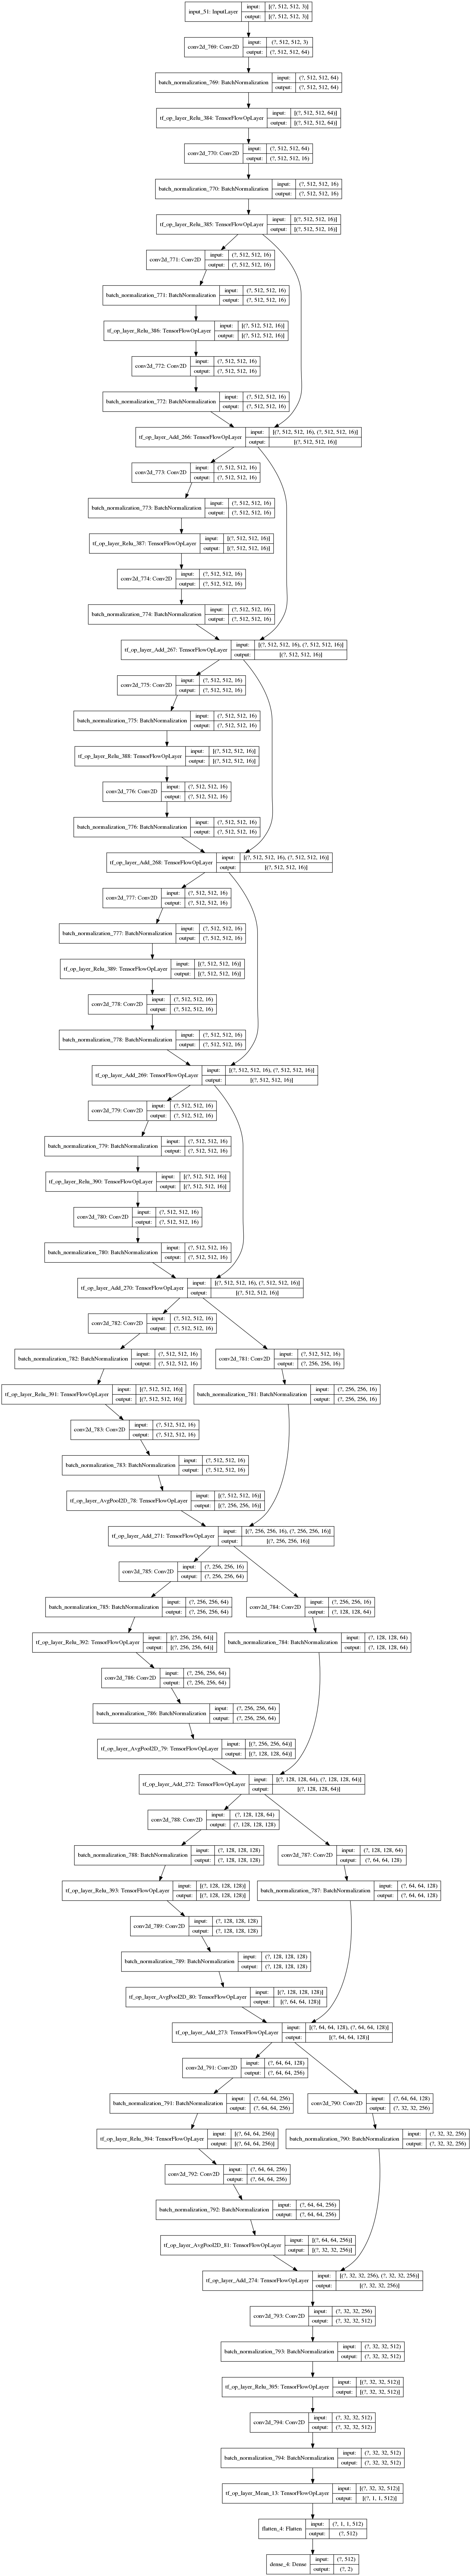

In [115]:
keras.utils.plot_model(sr_,to_file='model_plot.png', show_shapes=True, show_layer_names=True)